In [1]:
# import matplotlib.patches as patches
# import supervision as sv

import sys
import numpy as np
import glob
import os
import bz2
import pandas as pd
import geopandas as gpd
import pickle
from PIL import Image
import street_triangulation as tri
# import supervision as sv
import cv2
import math
import pdb
import contextily as ctx
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import matplotlib.pyplot as plt



pd.set_option('display.max_columns', None)

# sys.path.append(r'E:\Research\StreetView\gsv_pano')
sys.path.append(r'D:\Research\StreetView\gsv_pano')

from pano import GSV_pano
import utils

%load_ext autoreload
%autoreload 2

# Load results

In [2]:
ground_truth_file = r'..\Heyward_St_ground_truth\ground_truth_trunk_Heyward.shp'
estimate_file = r'..\Heyward_st_trunks\localized_trunks.shp'

In [3]:
SVI_gdf = gpd.read_file(estimate_file)
SVI_gdf

,index,distance,root_cente,root_botto,azimuth_ra,altitude_r,depth_h_di,median_wid,median_w_1,median_row,median_r_1,panoID,depth_x,depth_y,pano_x,pano_y,pano_headi,thumbnail_,trunk_head,image_file,azimuth_de,Type,h_distance,vertex_ang,pano_hea_1,tri_x,tri_y,left_col,right_col,diameter,folder,geometry
0,0,10.249231,38,538,-0.746878,-0.217234,10.008346,45.0,467,14,58,L9Jp_XEhrMmgm35YhruiRQ,608658.094720,239254.141746,608665.849204,239260.469065,183.581512,273.58,230.787061,L9Jp_XEhrMmgm35YhruiRQ_0.0_0.0_0_273.58_R90.jpg,-42.792939,trunk,10.174671,45.596996,3.204102,608657.965851,239254.036595,15.5,60.5,0.481638,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,POINT (608657.966 239254.037)
1,1,8.498947,260,540,-0.457378,-0.266850,8.198139,47.0,466,238,284,HkX4nzLQ1XWyjEprr4nFXA,608657.538018,239254.236044,608664.968408,239250.772117,186.197067,321.20,294.994165,HkX4nzLQ1XWyjEprr4nFXA_0.0_0.0_0_321.20_R135.jpg,-26.205835,trunk,7.726099,70.195901,3.249752,608657.965851,239254.036595,236.5,283.5,0.570725,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,POINT (608657.966 239254.037)
2,1,14.700000,272,477,-0.438337,-0.163009,14.505129,59.0,438,250,308,-apTLrvpSNEjvG8b5eWZ2A,609258.869246,239239.071973,609245.573759,239244.871005,93.675537,138.68,113.565165,-apTLrvpSNEjvG8b5eWZ2A_0.0_0.0_0_138.68_R45.jpg,-25.114835,trunk,14.273569,19.667530,1.634947,609258.656997,239239.164549,242.5,301.5,1.347659,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,POINT (609258.657 239239.165)
3,0,4.822246,233,669,-0.498936,-0.454633,4.332413,195.0,530,151,345,k5-O4GqXpRuptfifbbEKiA,609258.165025,239240.214943,609256.327428,239244.138339,93.485245,183.49,154.903067,k5-O4GqXpRuptfifbbEKiA_0.0_0.0_0_183.49_R90.jpg,-28.586933,trunk,5.492311,118.994568,1.631625,609258.656997,239239.164549,135.5,330.5,1.605610,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,POINT (609258.657 239239.165)
4,0,6.707345,998,592,0.759352,-0.286538,6.433874,49.0,493,975,1023,-apTLrvpSNEjvG8b5eWZ2A,609240.853975,239240.498549,609245.573759,239244.871005,93.675537,183.68,227.187662,-apTLrvpSNEjvG8b5eWZ2A_0.0_0.0_0_183.68_R90.jpg,43.507662,trunk,6.958948,133.290027,1.634947,609240.468789,239240.141709,973.5,1022.5,0.350424,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,POINT (609240.469 239240.142)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,0,10.437975,193,527,-0.557194,-0.232755,10.156511,33.0,456,177,209,ykx80oWPZZxJRj3fO4aDSQ,608961.892806,239278.025219,608959.015823,239268.284701,93.383476,48.38,16.455159,ykx80oWPZZxJRj3fO4aDSQ_0.0_0.0_0_48.38_L45.jpg,-31.924841,trunk,9.321979,78.024172,1.629849,608961.656412,239277.224868,176.5,209.5,0.432791,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,POINT (608961.656 239277.225)
635,0,14.193171,563,480,0.099282,-0.184456,13.952401,21.0,433,553,573,c_EHRnqMlsR0KzHFaBKF2g,608960.463556,239278.898329,608968.562102,239267.536857,93.827950,318.83,324.518433,c_EHRnqMlsR0KzHFaBKF2g_0.0_0.0_0_318.83_L135.jpg,5.688433,trunk,11.897315,50.039101,1.637607,608961.656412,239277.224868,552.5,573.5,0.483084,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,POINT (608961.656 239277.225)
636,0,10.437975,193,527,-0.557194,-0.232755,10.156511,33.0,456,177,209,ykx80oWPZZxJRj3fO4aDSQ,608961.892806,239278.025219,608959.015823,239268.284701,93.383476,48.38,16.455159,ykx80oWPZZxJRj3fO4aDSQ_0.0_0.0_0_48.38_L45.jpg,-31.924841,trunk,9.308567,78.024172,1.629849,608961.652613,239277.212005,176.5,209.5,0.432168,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,POINT (608961.653 239277.212)
637,1,12.373502,92,509,-0.687004,-0.186562,12.158793,34.0,448,75,108,c_EHRnqMlsR0KzHFaBKF2g,608961.495848,239277.431518,608968.562102,239267.536857,93.827950,3.83,-35.532457,c_EHRnqMlsR0KzHFaBKF2g_0.0_0.0_0_3.83_L90.jpg,-39.362457,trunk,11.889050,49.988211,1.637607,608961.652613,239277.212005,75.0,109.0,0.471968,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,POINT (608961.653 23927

In [4]:
GT_gdf = gpd.read_file(ground_truth_file).sort_values('created_at').reset_index()
# remove problematic image or trees

GT_gdf = GT_gdf.query("ec5_uuid != 'e8d995e2-57f3-440f-81ae-d2bc4dcbb837' ")
GT_gdf = GT_gdf.query("ec5_uuid != '189b47b6-fe34-4d3f-865f-f5958b7422e2' ")
GT_gdf = GT_gdf.query("ec5_uuid != 'fd44a744-a61c-437b-9e72-999622f00534' ")
GT_gdf = GT_gdf.query("ec5_uuid != '944d1310-12a8-4b9e-8654-2057f9cb9559' ")
GT_gdf = GT_gdf.query("ec5_uuid != '0d1177f7-d010-4ed8-b6af-f49b636863fd' ")
GT_gdf = GT_gdf.query("ec5_uuid != 'e6d5759f-003d-4a38-beb3-274bd773a8f2' ")
GT_gdf = GT_gdf.query("ec5_uuid != '18ab0b3b-33c4-4681-9f78-6d93c4255931' ")   # ??:?
GT_gdf = GT_gdf.query("ec5_uuid != '0109cf53-31aa-4406-aff9-97771900be1e' ")   # ??

GT_gdf = GT_gdf.reset_index()
GT_gdf

,level_0,index,ec5_uuid,created_at,uploaded_a,lon,lat,accuracy,raw_measur,diameter_m,photo,GSV_dia,folder2,Field,Field1,geometry
0,0,90,24763d55-4d76-498b-af6d-22d2799bb33a,2024-08-03T13:20:44.000Z,2024-08-03T15:21:08.000Z,-81.009828,33.991364,2,9-0,0.873188,24763d55-4d76-498b-af6d-22d2799bb33a_172269123...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (-81.00984 33.99121)
1,1,89,2254e854-3810-4374-9b8c-6df15bd4775f,2024-08-03T13:22:22.000Z,2024-08-03T15:21:10.000Z,-81.009753,33.991293,3,5-2,0.501275,2254e854-3810-4374-9b8c-6df15bd4775f_172269133...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (-81.00971 33.99120)
2,4,86,7eda123b-653b-4a20-98ec-ed68650783be,2024-08-03T13:27:15.000Z,2024-08-03T15:21:22.000Z,-81.009136,33.991180,3,0-11,0.088936,7eda123b-653b-4a20-98ec-ed68650783be_172269163...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (-81.00928 33.99117)
3,5,85,95f65adc-a6c1-494a-9e2f-7619fb7daff1,2024-08-03T13:28:57.000Z,2024-08-03T15:21:27.000Z,-81.009180,33.991195,2,9-6,0.921699,95f65adc-a6c1-494a-9e2f-7619fb7daff1_172269173...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (-81.00914 33.99117)
4,6,84,81dd72c0-dd3e-4863-a98b-07c4c79f4b57,2024-08-03T13:30:59.000Z,2024-08-03T15:21:32.000Z,-81.009052,33.991230,2,2-11,0.282978,81dd72c0-dd3e-4863-a98b-07c4c79f4b57_172269185...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (-81.00905 33.99115)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,85,5,acddebd5-fab4-48b4-8a29-89a8317a3517,2024-08-03T15:09:29.000Z,2024-08-03T15:26:47.000Z,-81.008578,33.990999,2,2-2,0.210212,acddebd5-fab4-48b4-8a29-89a8317a3517_172269776...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (-81.00857 33.99098)
79,86,4,21179720-ae03-4a12-b751-ae49278b1dc9,2024-08-03T15:10:43.000Z,2024-08-03T15:26:52.000Z,-81.008814,33.990955,3,7-0,0.679147,21179720-ae03-4a12-b751-ae49278b1dc9_172269784...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (-81.00876 33.99100)
80,87,3,4e91d6d3-e0f1-47eb-bc97-8836cbc89aab,2024-08-03T15:12:23.000Z,2024-08-03T15:26:57.000Z,-81.009415,33.991031,3,3-1,0.299148,4e91d6d3-e0f1-47eb-bc97-8836cbc89aab_172269794...,0.29,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,0.0,0.0,POINT (-81.00939 33.99103)
81,89,1,f4e9ae46-5436-4550-b0ea-c12b80ec3947,2024-08-03T15:13:59.000Z,2024-08-03T15:27:07.000Z,-81.009721,33.991076,3,1-11,0.185957,f4e9ae46-5436-4550-b0ea-c12b80ec3947_172269803...,0.15,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,0.0,0.0,POINT (-81.00971 33.99106)


In [227]:
# GT_gdf.loc[0, 'accuracy'] = 1000
# GT_gdf

In [5]:
import geopandas as gpd
from shapely.geometry import Point, box
import pandas as pd
# pd.set_option('display.max_colwidth', None) # Prevent truncation of column values
# pd.set_option('display.width', 1000)        # Set the display width to 1000 characters (adjust as needed)


def find_nearest_points_within_threshold(points_gdf, other_points_gdf, threshold):
    """
    For each point in `points_gdf`, find the nearest point in `other_points_gdf` within a distance threshold.
    
    Parameters:
    points_gdf (GeoDataFrame): GeoDataFrame containing the points to check.
    other_points_gdf (GeoDataFrame): GeoDataFrame containing the points to search from.
    threshold (float): Distance threshold within which to find the nearest point (in the same CRS as the GeoDataFrames).
    
    Returns:
    GeoDataFrame: A new GeoDataFrame with the original points and columns for the nearest point geometry and distance.
    """
    points_gdf['mean_diameter'] = -1.0
    points_gdf['used_mean_distance'] = -1.0
    points_gdf['measure_cnt'] = 0
    points_gdf['used_measure_cnt'] = 0
    # Ensure both GeoDataFrames have the same CRS
    if points_gdf.crs != other_points_gdf.crs:
        other_points_gdf = other_points_gdf.to_crs(points_gdf.crs)
    
    # Build a spatial index for the other points
    sindex = other_points_gdf.sindex

    # Initialize lists to store results
    nearest_points = []
    distances = []
    used_df_list = []

    # Iterate through each point in points_gdf
    for idx, point in enumerate(points_gdf.geometry):
        # print("ec5_uuid point:",idx, points_gdf.loc[idx, 'ec5_uuid'], point)
        # print("point.buffer(threshold).bounds):", point.buffer(threshold).bounds, box(*point.buffer(threshold).bounds))
        # Query the spatial index for possible matches within the threshold
        possible_matches_index = list(sindex.query(box(*point.buffer(threshold).bounds)))
        # print("point:", point)
        possible_matches = other_points_gdf.iloc[possible_matches_index]
        # print("possible_matches:", possible_matches)

        if not possible_matches.empty:
            # Filter further by checking actual distance to the point
            possible_matches = possible_matches[possible_matches.distance(point) <= threshold]
            points_gdf.loc[idx, 'measure_cnt'] =  len(possible_matches)
            mean_diameter, used_df = average_multi_measures(possible_matches)

            

            if mean_diameter > 0:
                # print("len(used_df):", used_df)
    
                points_gdf.loc[idx, 'used_measure_cnt'] =  len(used_df)
                points_gdf.loc[idx, 'mean_diameter'] =  mean_diameter
     
                points_gdf.loc[idx, 'used_mean_distance'] =  used_df['distance'].mean()

                used_df['ec5_uuid'] = points_gdf.loc[idx, 'ec5_uuid']

                used_df['field_diameter_m'] = points_gdf.loc[idx, 'diameter_m']
                # used_df['SVI_diameter'] = points_gdf.loc[idx, 'diameter']
                used_df['mean_diameter'] = mean_diameter

                used_df['error'] = used_df['mean_diameter'] - used_df['field_diameter_m'] 
                used_df['error_abs'] = used_df['error'].abs()
                used_df['error_%'] = used_df['error_abs'] / used_df['field_diameter_m']

                used_df_list.append(used_df)
                
        
    return points_gdf, used_df_list

def average_multi_measures(df, edge_pix = 5, img_width=1024, dis_factor=1.5):
    # compute the final tree diameters from the selected measures from street view images
    # Rules: 1) use the nearest image, and those not more far away than 50% distance of the nearest. 
    # 2) not close to the right/left most edge.
    df = df.query(f"left_col > {edge_pix}").query(f"right_col < {img_width - edge_pix}")
    df = df.sort_values('distance')
    # used_cnt = 0

    mean_diameter = 0

    used_df = None

    if not df.empty:
        nearest_dis = df.iloc[0]['distance']
        # used_df = df.query(f"distance < {nearest_dis * dis_factor}")
        used_df = df.query(f"distance < 20")
        mean_diameter = used_df.iloc[:]['diameter'].mean()  # select 4 at most
        # used_cnt = len(df)
    
    return mean_diameter, used_df

added_estimated_gdf, used_df_list = find_nearest_points_within_threshold(GT_gdf.to_crs(6569), SVI_gdf.to_crs(6569), 3)  # EPSG: 6569, South Carolina
# df_list[0]#.sort_values('distance')[['distance', 'diameter']]
# gdf.query("mean_diameter > 0")[['diameter_m', 'mean_diameter']]['mean_diameter']
pd.concat(used_df_list).to_csv(r"merged_results.csv", index=False)
# used_df_list[2]

In [14]:
# used_df_list

In [6]:
# compute the estimated diameter
added_estimated_gdf['error'] = added_estimated_gdf['mean_diameter'] - added_estimated_gdf['diameter_m']
added_estimated_gdf['error_abs'] = added_estimated_gdf['error'].abs()
added_estimated_gdf['error_%'] = added_estimated_gdf['error_abs'] / added_estimated_gdf['diameter_m']


added_estimated_gdf.query("mean_diameter > 0")['error_abs'].mean()# [['diameter_m', 'mean_diameter']]#['mean_diameter']
added_estimated_gdf.query("mean_diameter > 0")['error_%'].mean(), added_estimated_gdf.query("mean_diameter > 0")['error_abs'].mean()

(0.07420084979708595, 0.03775531332295255)

In [7]:
added_estimated_gdf.query("mean_diameter > 0")['error_%'].median(), added_estimated_gdf.query("mean_diameter > 0")['error_abs'].median()

(0.06850908220434485, 0.023843711828892)

In [8]:
added_estimated_gdf

,level_0,index,ec5_uuid,created_at,uploaded_a,lon,lat,accuracy,raw_measur,diameter_m,photo,GSV_dia,folder2,Field,Field1,geometry,mean_diameter,used_mean_distance,measure_cnt,used_measure_cnt,error,error_abs,error_%
0,0,90,24763d55-4d76-498b-af6d-22d2799bb33a,2024-08-03T13:20:44.000Z,2024-08-03T15:21:08.000Z,-81.009828,33.991364,2,9-0,0.873188,24763d55-4d76-498b-af6d-22d2799bb33a_172269123...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608690.860 239300.190),0.864600,12.588863,18,8,-0.008588,0.008588,0.009836
1,1,89,2254e854-3810-4374-9b8c-6df15bd4775f,2024-08-03T13:22:22.000Z,2024-08-03T15:21:10.000Z,-81.009753,33.991293,3,5-2,0.501275,2254e854-3810-4374-9b8c-6df15bd4775f_172269133...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608702.801 239298.965),0.457126,13.989218,6,5,-0.044149,0.044149,0.088073
2,4,86,7eda123b-653b-4a20-98ec-ed68650783be,2024-08-03T13:27:15.000Z,2024-08-03T15:21:22.000Z,-81.009136,33.991180,3,0-11,0.088936,7eda123b-653b-4a20-98ec-ed68650783be_172269163...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608742.486 239295.548),-1.000000,-1.000000,0,0,-1.088936,1.088936,12.244059
3,5,85,95f65adc-a6c1-494a-9e2f-7619fb7daff1,2024-08-03T13:28:57.000Z,2024-08-03T15:21:27.000Z,-81.009180,33.991195,2,9-6,0.921699,95f65adc-a6c1-494a-9e2f-7619fb7daff1_172269173...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608755.323 239295.568),0.902011,14.222376,6,6,-0.019688,0.019688,0.021360
4,6,84,81dd72c0-dd3e-4863-a98b-07c4c79f4b57,2024-08-03T13:30:59.000Z,2024-08-03T15:21:32.000Z,-81.009052,33.991230,2,2-11,0.282978,81dd72c0-dd3e-4863-a98b-07c4c79f4b57_172269185...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608763.695 239294.114),0.259134,13.415380,4,4,-0.023844,0.023844,0.084260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,85,5,acddebd5-fab4-48b4-8a29-89a8317a3517,2024-08-03T15:09:29.000Z,2024-08-03T15:26:47.000Z,-81.008578,33.990999,2,2-2,0.210212,acddebd5-fab4-48b4-8a29-89a8317a3517_172269776...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608808.748 239275.176),0.203308,8.025568,2,2,-0.006904,0.006904,0.032843
79,86,4,21179720-ae03-4a12-b751-ae49278b1dc9,2024-08-03T15:10:43.000Z,2024-08-03T15:26:52.000Z,-81.008814,33.990955,3,7-0,0.679147,21179720-ae03-4a12-b751-ae49278b1dc9_172269784...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608790.365 239277.246),0.665554,10.042103,8,6,-0.013592,0.013592,0.020014
80,87,3,4e91d6d3-e0f1-47eb-bc97-8836cbc89aab,2024-08-03T15:12:23.000Z,2024-08-03T15:26:57.000Z,-81.009415,33.991031,3,3-1,0.299148,4e91d6d3-e0f1-47eb-bc97-8836cbc89aab_172269794...,0.29,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,0.0,0.0,POINT (608732.282 239280.807),0.311569,10.005365,6,5,0.012421,0.012421,0.041521
81,89,1,f4e9ae46-5436-4550-b0ea-c12b80ec3947,2024-08-03T15:13:59.000Z,2024-08-03T15:27:07.000Z,-81.009721,33.991076,3,1-11,0.185957,f4e9ae46-5436-4550-b0ea-c12b80ec3947_172269803...,0.15,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,0.0,0.0,POINT (608702.734 239283.255),0.148410,10.454930,2,2,-0.037546,0.037546,0.201909


In [9]:
added_estimated_gdf = added_estimated_gdf.query("mean_diameter > 0")#.plot.scatter('diameter_m', 'mean_diameter')
added_estimated_gdf

,level_0,index,ec5_uuid,created_at,uploaded_a,lon,lat,accuracy,raw_measur,diameter_m,photo,GSV_dia,folder2,Field,Field1,geometry,mean_diameter,used_mean_distance,measure_cnt,used_measure_cnt,error,error_abs,error_%
0,0,90,24763d55-4d76-498b-af6d-22d2799bb33a,2024-08-03T13:20:44.000Z,2024-08-03T15:21:08.000Z,-81.009828,33.991364,2,9-0,0.873188,24763d55-4d76-498b-af6d-22d2799bb33a_172269123...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608690.860 239300.190),0.864600,12.588863,18,8,-0.008588,0.008588,0.009836
1,1,89,2254e854-3810-4374-9b8c-6df15bd4775f,2024-08-03T13:22:22.000Z,2024-08-03T15:21:10.000Z,-81.009753,33.991293,3,5-2,0.501275,2254e854-3810-4374-9b8c-6df15bd4775f_172269133...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608702.801 239298.965),0.457126,13.989218,6,5,-0.044149,0.044149,0.088073
3,5,85,95f65adc-a6c1-494a-9e2f-7619fb7daff1,2024-08-03T13:28:57.000Z,2024-08-03T15:21:27.000Z,-81.009180,33.991195,2,9-6,0.921699,95f65adc-a6c1-494a-9e2f-7619fb7daff1_172269173...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608755.323 239295.568),0.902011,14.222376,6,6,-0.019688,0.019688,0.021360
4,6,84,81dd72c0-dd3e-4863-a98b-07c4c79f4b57,2024-08-03T13:30:59.000Z,2024-08-03T15:21:32.000Z,-81.009052,33.991230,2,2-11,0.282978,81dd72c0-dd3e-4863-a98b-07c4c79f4b57_172269185...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608763.695 239294.114),0.259134,13.415380,4,4,-0.023844,0.023844,0.084260
5,7,83,3e43c2ea-57bf-46c1-9b80-cd46d1fe1479,2024-08-03T13:32:25.000Z,2024-08-03T15:21:37.000Z,-81.008832,33.991191,3,8-11,0.865103,3e43c2ea-57bf-46c1-9b80-cd46d1fe1479_172269194...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608785.716 239293.621),0.881519,11.179045,8,5,0.016416,0.016416,0.018975
6,8,82,69391140-6587-4de3-bd89-a317bd91af2f,2024-08-03T13:34:02.000Z,2024-08-03T15:21:42.000Z,-81.008692,33.991103,2,9-8,0.937869,69391140-6587-4de3-bd89-a317bd91af2f_172269203...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608792.228 239291.656),0.910909,13.471225,8,8,-0.026960,0.026960,0.028746
7,9,81,a688b71d-03a5-4ea7-a5d1-f9a6fcc109c3,2024-08-03T13:35:39.000Z,2024-08-03T15:21:47.000Z,-81.008545,33.991176,3,9-3,0.897444,a688b71d-03a5-4ea7-a5d1-f9a6fcc109c3_172269213...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608811.001 239291.263),0.901130,12.602781,10,10,0.003687,0.003687,0.004108
8,10,80,90e4db6c-8680-4a95-b3f4-5b1422037a58,2024-08-03T13:37:17.000Z,2024-08-03T15:21:52.000Z,-81.008379,33.991142,2,3-8,0.355743,90e4db6c-8680-4a95-b3f4-5b1422037a58_172269223...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608824.243 239289.570),0.373822,13.059530,2,2,0.018078,0.018078,0.050819
9,11,79,fb6d9351-1434-4794-a964-b1130c84165c,2024-08-03T13:38:27.000Z,2024-08-03T15:21:57.000Z,-81.008264,33.991101,2,8-2,0.792338,fb6d9351-1434-4794-a964-b1130c84165c_172269230...,NaN,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,NaN,NaN,POINT (608836.598 239288.140),0.741806,12.188662,10,9,-0.050532,0.050532,0.063776
11,13,77,c88bbb0e-7727-4b0b-9c10-46c907f44f06,2024-08-03T13:40:57.000Z,2024-08-03T15:22:15.000Z,-81.007853,33.991104,3,3-10,0.371914,c88bbb0e-7727-4b0b-9c10-46c907f44f06_172269245...,0.00,D:\OneDrive_PSU\OneDrive - The Pennsylvania St...,0.0,0.0,POINT (608883.810 239283.313),0.326228,9.805797,2,1,-0.045685,0.045685,0.122839


In [33]:
len(added_estimated_gdf.query("`error_%` < 0.1")) / len(added_estimated_gdf)

0.711864406779661

In [32]:
len(added_estimated_gdf.query("`error_%` > 0.15"))  

8

R squared: 0.9557396048509
reg.coef_: [[0.97275928]]


Text(0.05, 0.95, '(b)')

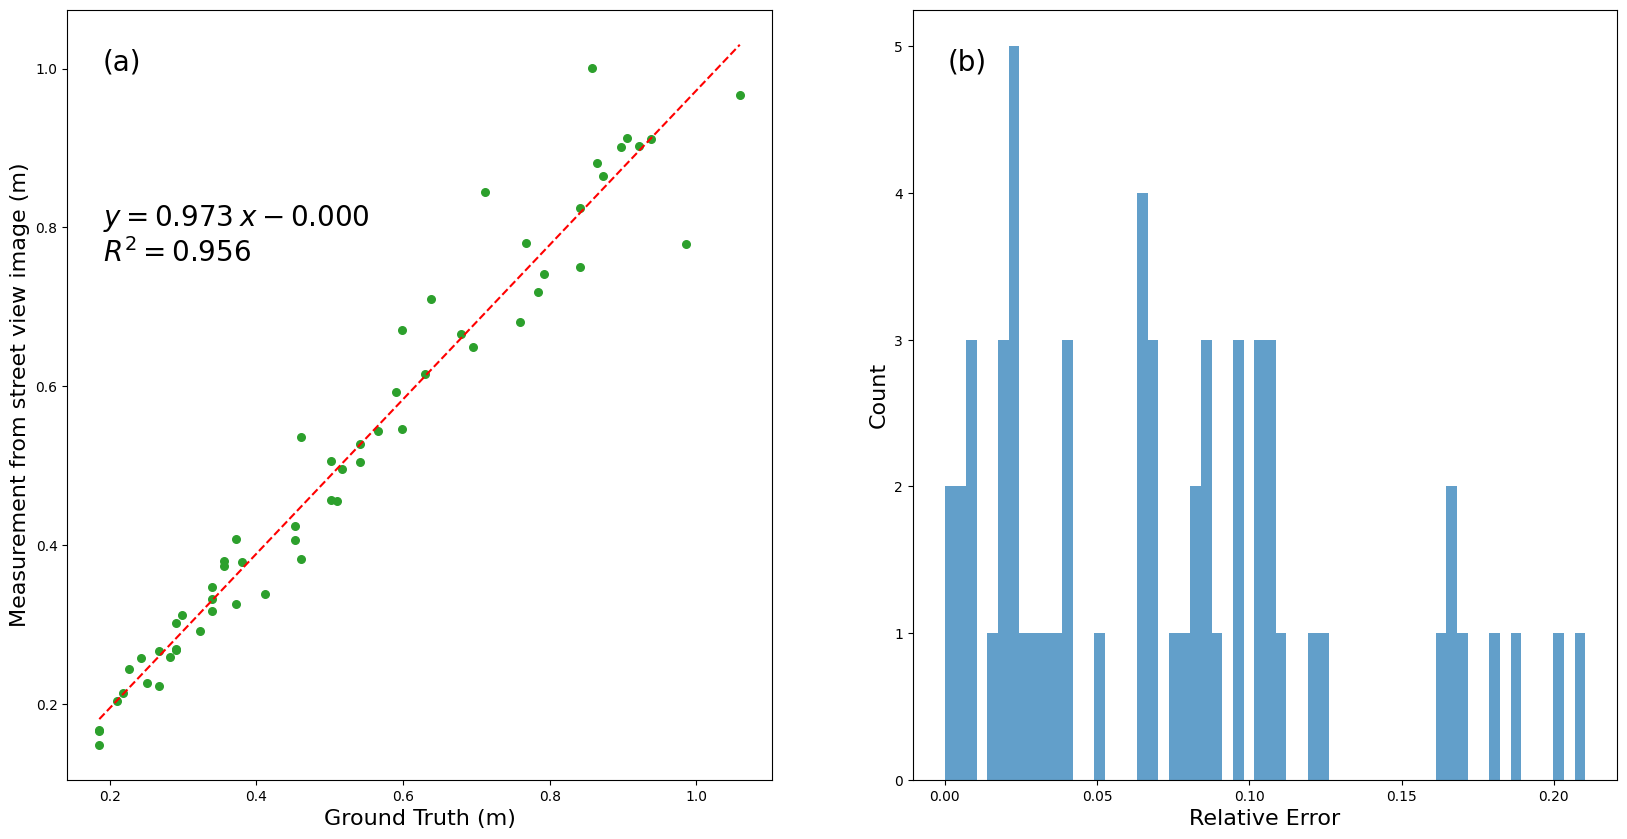

In [35]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import r2_score

def draw_r2_squared(ax2, x_true, y_observed):
    x_true = np.array(x_true).reshape((-1, 1))
    y_observed = np.array(y_observed).reshape((-1, 1))
    reg = LR().fit(x_true, y_observed)
    z = np.polyfit(x_true.ravel(), y_observed.ravel(), 1)
    p = np.poly1d(z)
    y_pred = p(x_true)
    R_squared = r2_score(y_observed, y_pred)
    # print()
    print("R squared:", R_squared)
    print("reg.coef_:", reg.coef_)
    text = f"$y={z[0]:0.3f}\:x{z[1]:+0.3f}$\n$R^2 = {R_squared:0.3f}$"
    ax2.scatter(x=x_true, y=y_observed, s=30, color="tab:green")
    ax2.text(0.05, 0.75, text, 
               transform=ax2.transAxes,
               fontsize=20,
               verticalalignment='top')
    
    # draw trend line
    line_ends = [min(x_true), max(x_true)]
    end_preds = p(line_ends)
    ax2.plot(line_ends, end_preds, 'r--')
    ax2.set_xlabel("Ground Truth (m)", fontsize=16)
    ax2.set_ylabel("Measurement from street view image (m)", fontsize=16)

fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)
draw_r2_squared(axs[0], added_estimated_gdf['diameter_m'], added_estimated_gdf['mean_diameter'])

# draw the error distribution as a histogram
# fig, axs = plt.subplots(figsize=(10, 10), row=1, ncols=1)
axs[1].hist(added_estimated_gdf['error_%'], bins=60, color='tab:blue', alpha=0.7)
axs[1].set_xlabel("Relative Error", fontsize=16)
axs[1].set_ylabel("Count", fontsize=16)

# add "(a)" and "(b)" labels to the subplots
axs[0].text(0.05, 0.95, "(a)",
              transform=axs[0].transAxes,
              fontsize=20,
              verticalalignment='top')      
axs[1].text(0.05, 0.95, "(b)",
              transform=axs[1].transAxes,
              fontsize=20,
              verticalalignment='top')    

In [10]:
added_estimated_gdf.query("mean_diameter > 0")['error_%'].max()

0.21029111381220936

<Axes: ylabel='Frequency'>

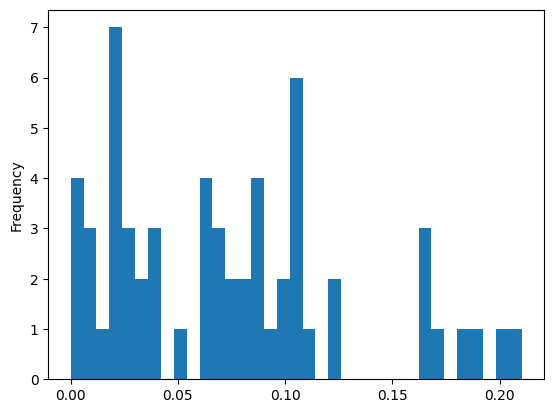

In [11]:
added_estimated_gdf.query("mean_diameter > 0")['error_%'].plot.hist(bins=35)

In [12]:
gdf.query("mean_diameter > 0")

NameError: name 'gdf' is not defined